In [2]:
import firebase_admin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from firebase_admin import credentials, firestore
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import os
import json
from sklearn.model_selection import train_test_split

# Firebase Initialization
cred = credentials.Certificate("adminkey.json")
firebase_admin.initialize_app(cred)
db = firestore.client()

import logging
logging.basicConfig(filename='training_log.txt', level=logging.INFO, format='%(asctime)s - %(message)s')

# Constants
INCLUDE_ONLY = ['Stephen', 'Lillian', 'Ren', 'Yuanheng', 'Ethan Shao']
ACTIVITIES = ['sit','walk','upstair']
CHUNK_SIZE = 2.375  # in seconds (can be a decimal)
SAMPLING_RATE = 100  # Hz
NUM_CLASSES = 3

In [3]:
# Data Structures
def fetch_data(collection_name, activities, include_only, time_start=500, time_end=6000):
    """Fetch and preprocess data from Firestore."""
    data, docs = [], []
    for person in db.collection(collection_name).stream():
        person_name = str(person.to_dict().get('name', ''))
        if person_name not in include_only:
            continue

        for activity in activities:
            for recording in db.collection(collection_name).document(person_name).collection(activity).stream():
                record = recording.to_dict()
                if 'acceleration' not in record:
                    continue

                docs.append(record)
                df = pd.DataFrame(record['acceleration'])
                
                if 'time' in df.columns:
                    filtered_df = df[(df['time'] >= time_start) & (df['time'] <= time_end)]
                    data.append(filtered_df)
                else:
                    raise ValueError("The 'acceleration' field must include a 'time' column.")
    return data, docs

# Fetch and preprocess training/testing data
training_data_raw, training_docs = fetch_data("training", ACTIVITIES, INCLUDE_ONLY)
testing_data_raw, testing_docs = fetch_data("testing", ACTIVITIES, INCLUDE_ONLY)

In [6]:
# Function to chunk data into smaller segments for training/testing
def chunk_data(data_raw, docs, chunk_size, activities, sampling_rate):
    """Split data into chunks and assign labels."""
    data, labels = [], []
    activity_distribution = np.zeros(len(activities))
    chunk_samples = int(chunk_size * sampling_rate)  # Convert time to sample count

    for i in range(len(data_raw)):
        num_chunks = len(data_raw[i]) // chunk_samples  # Number of full chunks
        for j in range(num_chunks):
            start = j * chunk_samples
            end = start + chunk_samples
            x = list(data_raw[i]["x"])[start:end]
            y = list(data_raw[i]["y"])[start:end]
            z = list(data_raw[i]["z"])[start:end]
            activity = docs[i]['activity']
            label = activities.index(activity)

            activity_distribution[label] += 1
            data.append([x, y, z])
            labels.append(label)

    return data, labels, activity_distribution

# Chunk the data
training_data, training_labels, training_distribution = chunk_data(training_data_raw, training_docs, CHUNK_SIZE, ACTIVITIES, SAMPLING_RATE)
testing_data, testing_labels, testing_distribution = chunk_data(testing_data_raw, testing_docs, CHUNK_SIZE, ACTIVITIES, SAMPLING_RATE)

In [7]:
from tabulate import tabulate #for table formatting

#Calculate the number of training and testing samples
num_training_samples = len(training_data)
num_testing_samples = len(testing_data)

#table
summary_table = [["training", num_training_samples], ["testing", num_testing_samples]]

#print
print("dataset summary:")
print(tabulate(summary_table, headers = ["Dataset", "number of chunks"], tablefmt="pretty"))

print("Training Activities Count")
for i, activity in enumerate(ACTIVITIES):
    print(f"{activity}: {int(training_distribution[i])} chunks")

print("\nTesting Activity Count")
for i, activity in enumerate(ACTIVITIES):
    print(f"{activity}:{int(testing_distribution[i])} chunks")
print(len(training_data))
print(len(testing_data))
print(np.array(training_data).shape)
print(len(training_data_raw))
print(len(testing_data_raw))

dataset summary:
+----------+------------------+
| Dataset  | number of chunks |
+----------+------------------+
| training |        60        |
| testing  |        60        |
+----------+------------------+
Training Activities Count
sit: 20 chunks
walk: 20 chunks
upstair: 20 chunks

Testing Activity Count
sit:20 chunks
walk:20 chunks
upstair:20 chunks
60
60
(60, 3, 237)
30
30


In [8]:
# Convert the data to NumPy arrays
training_data = np.array(training_data)
testing_data = np.array(testing_data)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(training_data.reshape(-1, training_data.shape[-1])).reshape(training_data.shape)
X_test = scaler.transform(testing_data.reshape(-1, testing_data.shape[-1])).reshape(testing_data.shape)

# Convert to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)  # Shape: (num_samples, 3, chunk_size*100)
y_train = torch.tensor(training_labels, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(testing_labels, dtype=torch.long)

# Create TensorDataset and DataLoader for batching
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)

In [10]:
class OptimizedLSTMModel(nn.Module):
    def __init__(self, num_classes, input_channels, seq_length, hidden_size=128, num_layers=2):
        super(OptimizedLSTMModel, self).__init__()
        self.seq_length = seq_length
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer expects input of shape (batch_size, seq_length, input_size)
        self.lstm = nn.LSTM(input_channels, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layer to output predictions
        self.fc = nn.Linear(hidden_size, num_classes)
        
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # LSTM requires a hidden state and cell state to be initialized
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Pass through LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Use the output of the last timestep for classification
        out = out[:, -1, :]  # Take the last hidden state
        out = self.dropout(out)
        
        # Pass through the fully connected layer
        out = self.fc(out)
        return out

In [11]:
# Path to save best model and metadata
BEST_MODEL_PATH = "best_model.pth"
BEST_METADATA_PATH = "best_model.json"

# Function to save best model
def save_best_model(epoch, model, optimizer, loss, accuracy, train_losses, test_losses):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy,
        'train_losses': train_losses,
        'test_losses': test_losses,
    }
    torch.save(checkpoint, BEST_MODEL_PATH)


    # Save metadata
    with open(BEST_METADATA_PATH, "w") as f:
        json.dump({"epoch": epoch, "test_loss": test_loss, "avg_accuracy": avg_accuracy}, f)

# Function to load best model if exists
def load_best_model(model, optimizer, best_model_path=BEST_MODEL_PATH):
    if os.path.exists(best_model_path):
        checkpoint = torch.load(best_model_path)
        
        # Print checkpoint keys to understand its structure
        print("Checkpoint keys:", checkpoint.keys())
        
        # Load model weights
        model_state_dict = model.state_dict()
        checkpoint_state_dict = checkpoint['model_state_dict']
        
        # Filter out incompatible keys
        filtered_checkpoint_state_dict = {k: v for k, v in checkpoint_state_dict.items() if k in model_state_dict}
        model_state_dict.update(filtered_checkpoint_state_dict)
        model.load_state_dict(model_state_dict)
        
        # Optionally, don't load the optimizer state to avoid the error
        # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        # Load other metadata if available
        start_epoch = checkpoint.get('epoch', 0)
        best_loss = checkpoint.get('loss', float('inf'))  # Default to infinity if loss is missing
        best_avg_accuracy = checkpoint.get('accuracy', 0)  # Default to 0 if accuracy is missing
        
        # If train_losses and test_losses aren't saved, return empty lists or placeholders
        train_losses = checkpoint.get('train_losses', [])
        test_losses = checkpoint.get('test_losses', [])
        
        return start_epoch, best_loss, best_avg_accuracy, train_losses, test_losses
    else:
        print("No checkpoint found, starting from scratch.")
        # Return default values
        return 0, float('inf'), 0, [], []



In [12]:
def evaluate_model(loader, model, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.transpose(1, 2)  # Transpose inputs to (batch_size, seq_length, channels)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(loader)
    accuracy = (correct / total) * 100
    return avg_loss, accuracy

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from scipy.interpolate import interp1d
from torch.optim import Adam

# Data Augmentation Functions
def add_jitter(batch_X, noise_level=0.01):
    noise = torch.randn_like(batch_X) * noise_level
    return batch_X + noise

def scale_signal(batch_X, scale_range=(0.9, 1.1)):
    scale_factor = torch.FloatTensor(batch_X.shape[0], 1, 1).uniform_(*scale_range)
    return batch_X * scale_factor

def time_warp(batch_X, sigma=0.2):
    batch_size, num_channels, seq_length = batch_X.shape
    time_steps = np.arange(seq_length)
    warping_curve = np.cumsum(np.random.normal(0, sigma, size=(batch_size, seq_length)), axis=1)
    warping_curve = (warping_curve - warping_curve.min(axis=1, keepdims=True)) / \
                    (warping_curve.max(axis=1, keepdims=True) - warping_curve.min(axis=1, keepdims=True)) * seq_length
    warped_X = torch.zeros_like(batch_X)
    for i in range(batch_size):
        for j in range(num_channels):
            f = interp1d(time_steps, batch_X[i, j, :].cpu().numpy(), kind='linear', fill_value='extrapolate')
            warped_X[i, j, :] = torch.tensor(f(warping_curve[i]), dtype=batch_X.dtype)
    return warped_X

def random_crop(batch_X, crop_size=0.9, target_length=None):
    batch_size, num_channels, seq_length = batch_X.shape
    new_length = int(seq_length * crop_size)
    start_idx = torch.randint(0, seq_length - new_length + 1, (batch_size,))
    cropped_X = torch.zeros(batch_size, num_channels, new_length)
    for i in range(batch_size):
        cropped_X[i] = batch_X[i, :, start_idx[i]:start_idx[i] + new_length]
    
    if target_length is not None:
        if new_length < target_length:
            padding = torch.zeros(batch_size, num_channels, target_length - new_length)
            cropped_X = torch.cat([cropped_X, padding], dim=2)
        elif new_length > target_length:
            cropped_X = cropped_X[:, :, :target_length]
    return cropped_X

def permute_segments(batch_X, num_segments=5):
    batch_size, num_channels, seq_length = batch_X.shape
    segment_length = seq_length // num_segments
    permuted_X = batch_X.clone()
    for i in range(batch_size):
        perm = torch.randperm(num_segments)
        for j in range(num_segments):
            permuted_X[i, :, j * segment_length:(j + 1) * segment_length] = \
                batch_X[i, :, perm[j] * segment_length:(perm[j] + 1) * segment_length]
    return permuted_X

In [14]:
# Initialize model, optimizer, and loss function
model = OptimizedLSTMModel(num_classes=NUM_CLASSES, input_channels=3, seq_length=int(CHUNK_SIZE * 100))
optimizer = Adam(model.parameters(), lr=0.02, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, min_lr=1e-5)

# Load best model if exists
start_epoch, best_loss, best_avg_accuracy, train_losses, test_losses = load_best_model(model, optimizer)

Checkpoint keys: dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'loss', 'accuracy', 'train_losses', 'test_losses'])


C:\Users\minsu\AppData\Local\Temp\ipykernel_23000\2561067316.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path)


In [18]:
# Your existing training loop
epochs = 50
for epoch in range(0, epochs):
    model.train()
    # [Your existing training loop code]
    

# Insert the new code HERE
chunk_sizes = [
    0.25, 0.5, 1.0, 1.375, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 5
]
accuracies = []

for chunk_size in chunk_sizes:
    print(f"\nTesting chunk size: {chunk_size} seconds")
    
    # Re-chunk data with new chunk size
    training_data, training_labels, _ = chunk_data(training_data_raw, training_docs, chunk_size, ACTIVITIES, SAMPLING_RATE)
    testing_data, testing_labels, _ = chunk_data(testing_data_raw, testing_docs, chunk_size, ACTIVITIES, SAMPLING_RATE)
    
    # Convert to numpy arrays and normalize
    training_data = np.array(training_data)
    testing_data = np.array(testing_data)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(training_data.reshape(-1, training_data.shape[-1])).reshape(training_data.shape)
    X_test = scaler.transform(testing_data.reshape(-1, testing_data.shape[-1])).reshape(testing_data.shape)
    
    # Convert to torch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(training_labels, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(testing_labels, dtype=torch.long)
    
    # Create data loaders
    train_data = TensorDataset(X_train, y_train)
    test_data = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)
    
    # Initialize LSTM model with current chunk size
    model = OptimizedLSTMModel(
        num_classes=NUM_CLASSES, 
        input_channels=3, 
        seq_length=int(chunk_size * SAMPLING_RATE)
    )
    optimizer = Adam(model.parameters(), lr=0.02, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    # Training loop (simplified version of your original)
    epochs = 100  # Reduced for testing multiple chunk sizes
    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.transpose(1, 2)  # Adjust shape for LSTM
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    # Evaluate using your existing evaluate_model function
    test_loss, test_accuracy = evaluate_model(test_loader, model, criterion)
    accuracies.append(test_accuracy)
    print(f"Chunk size {chunk_size}s - Test Accuracy: {test_accuracy:.2f}%")


Testing chunk size: 0.25 seconds
Chunk size 0.25s - Test Accuracy: 56.06%

Testing chunk size: 0.5 seconds
Chunk size 0.5s - Test Accuracy: 86.67%

Testing chunk size: 1.0 seconds
Chunk size 1.0s - Test Accuracy: 66.00%

Testing chunk size: 1.375 seconds
Chunk size 1.375s - Test Accuracy: 74.17%

Testing chunk size: 2.0 seconds
Chunk size 2.0s - Test Accuracy: 76.67%

Testing chunk size: 2.25 seconds
Chunk size 2.25s - Test Accuracy: 55.00%

Testing chunk size: 2.5 seconds
Chunk size 2.5s - Test Accuracy: 73.33%

Testing chunk size: 2.75 seconds
Chunk size 2.75s - Test Accuracy: 48.33%

Testing chunk size: 3.0 seconds
Chunk size 3.0s - Test Accuracy: 33.33%

Testing chunk size: 3.25 seconds
Chunk size 3.25s - Test Accuracy: 30.00%

Testing chunk size: 3.5 seconds
Chunk size 3.5s - Test Accuracy: 70.00%

Testing chunk size: 3.75 seconds
Chunk size 3.75s - Test Accuracy: 30.00%

Testing chunk size: 4.0 seconds
Chunk size 4.0s - Test Accuracy: 43.33%

Testing chunk size: 5 seconds
Chunk 

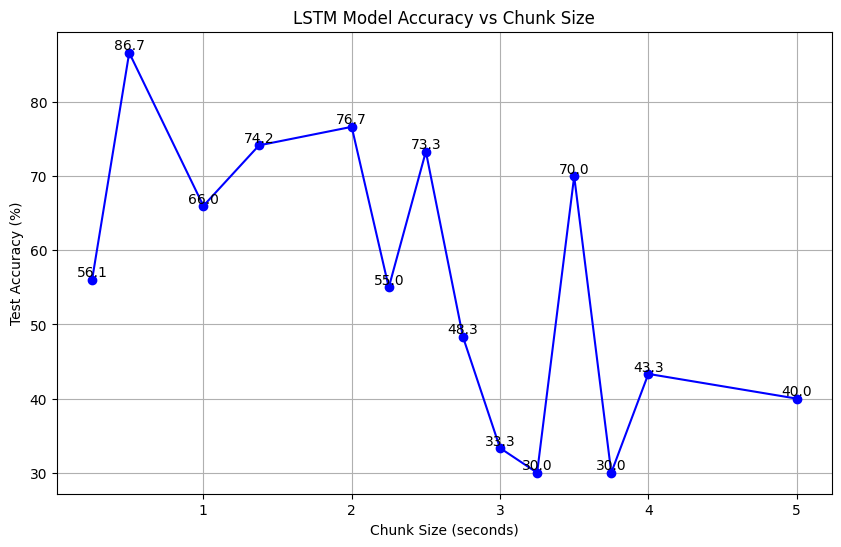


LSTM Results Summary:
 Chunk Size (s)  Accuracy (%)
          0.250     56.060606
          0.500     86.666667
          1.000     66.000000
          1.375     74.166667
          2.000     76.666667
          2.250     55.000000
          2.500     73.333333
          2.750     48.333333
          3.000     33.333333
          3.250     30.000000
          3.500     70.000000
          3.750     30.000000
          4.000     43.333333
          5.000     40.000000


In [19]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(chunk_sizes, accuracies, 'bo-')
plt.xlabel('Chunk Size (seconds)')
plt.ylabel('Test Accuracy (%)')
plt.title('LSTM Model Accuracy vs Chunk Size')
plt.grid(True)

# Add accuracy values as text
for i, (x, y) in enumerate(zip(chunk_sizes, accuracies)):
    plt.text(x, y, f'{y:.1f}', ha='center', va='bottom')

plt.savefig('lstm_chunk_size_vs_accuracy.png')
plt.show()

# Print results table
results = pd.DataFrame({
    'Chunk Size (s)': chunk_sizes,
    'Accuracy (%)': accuracies
})
print("\nLSTM Results Summary:")
print(results.to_string(index=False))

In [25]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Activities for the Confusion matrix
ACTIVITIES = ['sit', 'walk','upstair']

# Model evaluation (confusion matrix)
model.eval()
all_predictions = []
all_labels = []

# Loop through the test loader to collect predictions and true labels
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Compute the confusion matrix, explicitly specifying the labels
conf_matrix = confusion_matrix(all_labels, all_predictions, labels=[0, 1, 2]) 

# Assuming conf_matrix and ACTIVITIES are already defined
class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)  # Compute per-class accuracy

# Display the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=ACTIVITIES)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Add per-class accuracy text
for i, activity in enumerate(ACTIVITIES):
    acc_text = f"{class_accuracies[i] * 100:.2f}%"
    ax.text(
        len(ACTIVITIES) + 0.3, i, acc_text, 
        fontsize=12, verticalalignment='center', color='black'
    )

plt.title("Confusion Matrix for Activities with Per-Class Accuracy")
plt.show()

RuntimeError: input.size(-1) must be equal to input_size. Expected 3, got 237

In [ ]:
import torch.nn.functional as F

model.eval()  # Set model to evaluation mode
incorrect_samples = []

with torch.no_grad():  # Disable gradient computation
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)  # Get raw logits
        probabilities = F.softmax(outputs, dim=1)  # Convert to probabilities
        predicted_labels = torch.argmax(probabilities, dim=1)  # Get predicted class
        confidence_scores = torch.max(probabilities, dim=1).values  # Get max confidence

        # Find incorrect predictions
        incorrect_indices = (predicted_labels != batch_y)
        for i in range(len(batch_y)):
            if incorrect_indices[i]:
                incorrect_samples.append({
                    "True Label": batch_y[i].item(),
                    "Predicted Label": predicted_labels[i].item(),
                    "Confidence": confidence_scores[i].item(),
                    "Probabilities": probabilities[i].tolist()
                })

# Print results
for sample in incorrect_samples:
    print(f"True Label: {sample['True Label']}, Predicted: {sample['Predicted Label']}, Confidence: {sample['Confidence']:.4f}")
    print(f"Full Probabilities: {sample['Probabilities']}")

True Label: 1, Predicted: 2, Confidence: 0.5379
Full Probabilities: [0.04630952328443527, 0.40478968620300293, 0.5378606915473938, 0.0032725243363529444, 0.0037186944391578436, 0.0018561289180070162, 0.0015050942311063409, 0.0006875882390886545]
True Label: 1, Predicted: 2, Confidence: 0.6603
Full Probabilities: [0.012942157685756683, 0.3238711655139923, 0.6603409051895142, 0.0006900696316733956, 0.0012600854970514774, 0.00047482800437137485, 0.0003185397945344448, 0.00010225101141259074]
True Label: 2, Predicted: 1, Confidence: 0.5808
Full Probabilities: [0.002849593525752425, 0.5807549357414246, 0.4157315492630005, 0.00019912587595172226, 0.000295086792903021, 0.00010057010513264686, 5.421382957138121e-05, 1.4962002751417458e-05]
True Label: 2, Predicted: 1, Confidence: 0.5663
Full Probabilities: [0.004601947031915188, 0.5663013458251953, 0.42831793427467346, 0.0002489405160304159, 0.0003278449294157326, 0.00011758197069866583, 6.75682895234786e-05, 1.6763236999395303e-05]
True Label